In [34]:
# Импортируем необходимые библиотеки
import math
from sympy import simplify, symbols, Eq, sympify, solveset, solve, Float
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from IPython.display import display as d

In [35]:

# # Исходные данные
# # Параметры задачи (вариант 5)
h0 = 4.4 # Высота жидкости в компенсационной емкости
h1 = 0.2 # Постоянная высота жидкости в рабочей емкости
S = 0.4 # Площадь сечения рабочей емкости (зеркала жидкости)
G = 3400 # Массовый расход ткани, г/с
m1 = 0.12 # Уровень влажности ткани до окраски
m2 = 1.0 # Уровень влажности ткани после окраски
ρ = 500 # Плотность ткани, кг/м3
tп = 15 # Время переходного процесса, с

g = 9.8 # Ускорение свободного падения, м/с2

φ_max = 14 # Угол вращения вала исполнительного двигателя, 
           #соответствующий перемещению клапана f1 от 0..fmax
f_max = 3 # Максимальное проходное сечения проходного клапана f1

ε = 0.6 # Коэффициент расхода жидкости через клапан
t_п = 15 # Время переходного процесса объекта управления, с
m = 3 # 3..4 # Масса сильфона, кг (?)
k_дин = 1.5 # 1.5..2.5 
M_ст = 1.5 # 1.5..3.0

In [36]:
# Функция для округления чисел в выражении sympy
def r(expression, decimal_places=2):
    def round_numbers(expr, decimal_places):
        if expr.is_Float:
            return Float(round(expr, decimal_places))
        elif expr.is_Number:
            return expr
        elif expr.args:
            args = [round_numbers(arg, decimal_places) for arg in expr.args]
            return expr.func(*args)
        else:
            return expr
    # Convert the expression to a SymPy expression
    expr = sympify(expression)

    # Round the floating-point numbers in the expression
    rounded_expr = round_numbers(expr, decimal_places)

    return rounded_expr

In [79]:
# Проходное сечение клапана в номинальном режиме
# f1 = ((G * math.pow(10, -3) * (m1 - m2))) / (ε * math.sqrt(2 * g) * (h0 - h1)) # * 10^-3 м2/с
f1 = (1 / (ρ*ε)) * (abs(G - (m2 - m1)) 
                    / 
                    (math.sqrt(2 * g) * (h0 - h1))) # * math.pow(10, -2) m2
# f1 = f1 * pow(10, -2)

# Постоянная времени объекта управления, с
T_о = ((2*S) * math.sqrt(h0 - h1)) / (f1 * ε * math.sqrt(2 * g))  # +
# Коэффициент передачи объекта управления
k_о = (2 * (h0 - h1)) / f1 # * 10^-3
# Максимальная величина проходного сечения рег. клапана
f1_max = 4 * f1
# Коэффициент передачи регулирующего графика
k_ро = f1_max / φ_max # м3/с
print(f'{f1=}*10^-2 {T_о=}\n{k_о=} {f1_max=} {k_ро=}')


f1=0.6093515442308131*10^-2 T_о=1.0129020032721485
k_о=13.785145995819793 f1_max=2.4374061769232522 k_ро=0.17410044120880372


In [105]:
## Рассчитываем мощность двигателя
# Скорость вращения регулирующего органа
n_ро = ((0.2 * φ_max) / t_п) * 60 # об/мин
# Мощность двигателя
k_дин = 2  # Коэффтцтент динамической нагрузки для двигателя < 1 кВт равен 2
P = (k_дин * (M_ст) * (n_ро)) / 0.975 # ~ 27.7 Вт

print(f'{k_дин=} {n_ро=} {P=}')

k_дин=2 n_ро=11.200000000000001 P=34.46153846153847


In [84]:
# Загрузим данные по двигателям из таблицы drives.xlsx с параметрами двигателей
df_drives = pd.read_excel('drives.xlsx', sheet_name='drives', index_col=False).transpose()
df_drives.columns = ['ID', 'U', 'P', 'n_дв', 'I_я', 'R_я', 'I']
df_drives

,ID,U,P,n_дв,I_я,R_я,I
1,СЛ-267,110,27,4000,0.8,10,0.065
2,СЛ-261,110,24,3600,0.5,51,0.065
3,СЛ-367,110,32,2500,0.9,1.5,0.125
4,СЛ-321,110,38,3000,0.7,2.7,0.125
5,СЛ-369,110,55,3600,0.55,19,0.15
6,СЛ-521,110,77,3000,1.1,8.5,0.25
7,СЛ-561,110,170,3000,1.9,3.6,0.55
8,СЛ-661,110,230,2400,2.6,1.73,0.925


In [103]:
# Выбираем двигатель с мощностью, большей или равной P
# Все заголовки столбцов после первого - это модели двигателей
# Строки P_п с соответствующими столбцами - полезная мощность двигателя
condition = df_drives['P'] >= math.ceil(P)
selected_drives = df_drives.loc[condition]
selected_drives_dict = selected_drives.to_dict(orient='records')[0]
selected_drives_dict
ID = selected_drives_dict['ID']
U = selected_drives_dict['U']
P_дв = selected_drives_dict['P']
I = selected_drives_dict['I']
n_дв = selected_drives_dict['n_дв']
R_я = selected_drives_dict['R_я']
I_я = selected_drives_dict['I_я']
print(f'Выбранный двигатель: {ID}:\n{U=} {P_дв=} {I=}\n{n_дв=} {R_я=} {I_я=}')

Выбранный двигатель: СЛ-321:
U=110 P_дв=38 I=0.125
n_дв=3000 R_я=2.7 I_я=0.7


### Рассчитываем постоянные и коэффиценты для системы

In [88]:
# Постоянная двигателя
C_дв = (U - I*R_я) / (n_дв * (2*math.pi/60))
# Постоянная времени двигателя
T_м = (I * R_я) / (C_дв * C_дв)
# Коэффициент двигателя
k_дв = 1 / C_дв
Wдв_p = k_дв / (T_м * ρ + 1) * ρ
# Коэффициент редуктора
k_р = n_ро / n_дв
C = 1000 # Н/м # Уточнить значение
k_d = (ρ * g * S * pow(10, -2)) / C
# Постоянная вращения
T_k = math.sqrt(m / (2 * C))
T_d = 2 * S * T_k
# Сравнивающее устровйство
k_тс = 10
# Магнитное усиление
k_му = 100; T_му = 1
# Регулирующий орган
q_потр = f_max * ε * math.sqrt((2 * g) * (h0 - h1)) # м3/с, объемный секундный расход жидкости из емкости


print(f'{T_м=} {k_р=} {k_d=} {T_k=}\n{T_d=} {k_тс=} {k_му=} {k_му=}')

T_м=2.7698562958429114 k_р=0.0037333333333333337 k_d=0.019600000000000003 T_k=0.03872983346207417
T_d=0.030983866769659335 k_тс=10 k_му=100 k_му=100


In [ ]:
# Для удобства выводим все промежуточные значения в округлённом виде
print(f'{k_о=:.2f}\t{k_ро=:.2f}\t{k_дин=:.3f}\n{k_р=:.2f}\t{k_d=:.3f}\t{k_тс=:.2f}\t{k_дв=:.2f} \n')
print(f'{T_о=:.2f}\t{T_м=:.2f}\t{T_k=:.2f}\t{T_d=:.2f}\t{T_му=:.2f}')


k_о=13.79	k_ро=0.17	k_дин=1.500
k_р=0.00	k_d=0.020	k_тс=10.00	k_дв=2.38 

T_о=1.01	T_м=0.60	T_k=0.04	T_d=0.03	T_му=1.00


Подставляем полученные переменные согласно формулам:

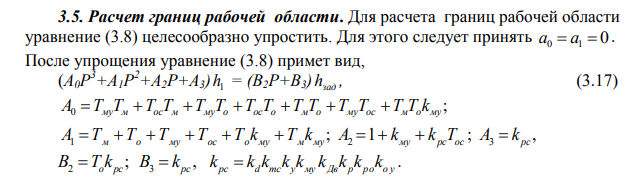

, где:

k_рс = k_о * k_d * k_дв * k_р * k_ро * k_тс * k_у * k_му

k_рс = γ * _k_у_ * _k_му_

Соотвенно A0, A1, A2, A3 будут выражены в следующем виде:

In [89]:
# Выражаем A0, A1, A2, A3 и k_рс через коэффициенты передачи
T_ос, k_му, k_у = symbols('T_ос k_му k_у')
k_рс = k_о * k_d * k_дв * k_р * k_ро * k_тс * k_у * k_му # Коэффициент передачи разомкнутой системы

# Выражение для A0
A0 = T_му*T_м + T_ос*T_м + T_му*T_о + T_ос*T_о + T_м*T_о + T_му*T_ос + T_м*T_о*k_му
A1 = T_м + T_о + T_му + T_ос + T_о*k_му + T_м*k_му
A2 = 1.0 + k_му + k_рс*T_ос
A3 = k_рс
B2 = T_о*k_рс
B3 = k_рс
# Упрощение выражения A0
A0 = simplify(A0)
A1 = simplify(A1)
A2 = simplify(A2)
A3 = simplify(A3)

d(Eq(symbols('k_рс'), r(k_рс, 5)))
d(Eq(symbols('A0'), r(A0)))
d(Eq(symbols('A1'), r(A1)))
d(Eq(symbols('A2'), r(A2, 5)))
d(Eq(symbols('A3'), r(A3, 5)))


Eq(k_рс, 0.00503*k_му*k_у)

Eq(A0, 4.78*T_ос + 2.81*k_му + 6.59)

Eq(A1, T_ос + 3.78*k_му + 4.78)

Eq(A2, 0.00503*T_ос*k_му*k_у + k_му + 1.0)

Eq(A3, 0.00503*k_му*k_у)

Приводим уравнения к функциям для рассчёта коэффициентов

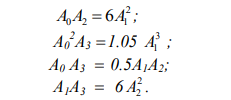

Пусть коэффиент усиления магнитного усилителя k_му = 100

In [90]:
k_му_value = 100

# Присваиваем значение k_му в уравнениях
A0 = A0.subs(k_му, k_му_value)
A1 = A1.subs(k_му, k_му_value)
A2 = A2.subs(k_му, k_му_value)
A3 = A3.subs(k_му, k_му_value)

eq1 = simplify(Eq(A0 * A2, 6 * A1**2))
eq2 = simplify(Eq(A0**2 * A3, 1.05 * A1**3))
eq3 = simplify(Eq(A0 * A3, 0.5 * A1 * A2))
eq4 = simplify(Eq(A1 * A3, 6 * A2))

d(r(eq1))
d(r(eq2))
d(r(eq3))
d(r(eq4))


Eq(880403.29, (4.78*T_ос + 287.15)*(0.5*T_ос*k_у + 101.0))

Eq(59018057.37, 41482.64*k_у*(0.02*T_ос + 1)**2)

Eq(k_у*(2.41*T_ос + 144.46), (0.5*T_ос + 191.53)*(0.5*T_ос*k_у + 101.0))

Eq(0.5*k_у*(T_ос + 383.06), 3.02*T_ос*k_у + 606.0)

Получаем уравнения функций для k_y1, k_y2, k_y3, k_y4

In [91]:
# Получаем уравнения функций для каждого из коэффициентов
k_у1 = simplify(solveset(eq1, k_у))
k_у2 = simplify(solveset(eq2, k_у))
k_у3 = simplify(solveset(eq3, k_у))
k_у4 = simplify(solveset(eq4, k_у))

d(r(k_у1))
d(r(k_у2))
d(r(k_у3))
d(r(k_у4))


{(11.93*T_ос**2 + 8176.57*T_ос + 1692304.61)/(T_ос*(4.78*T_ос + 287.15))}

{1422.72/(0.02*T_ос + 1)**2}

{(-0.35*T_ос - 133.9)/(0.65*T_ос - 1.0)}

{-3.14/(0.01*T_ос - 1.0)}

Строим графики для кажного коэффициента

In [92]:
# Функция для извлечения значения из выражения
# Задаём диапазон значений для T_ос
start_value = 0.1
end_value = 17

In [69]:
# Функция для построения графика
T_ос_values = np.linspace(start_value, end_value, 20)

def f(expr, sym, val):
    result = expr.subs(sym, val)
    return float(list(result)[0])

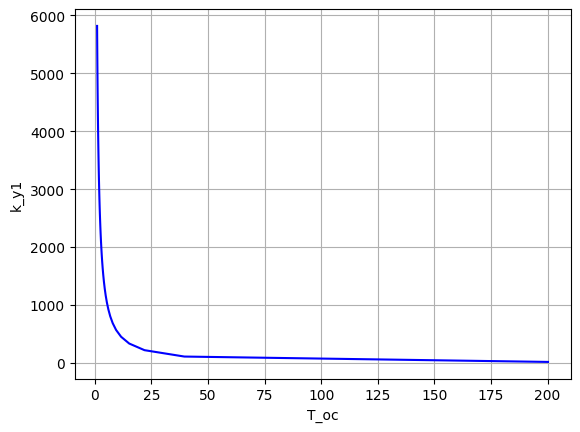

In [107]:
# Строим график k_у1
k_y1_values = [f(k_у1, T_ос, T_ос_value) for T_ос_value in T_ос_values]

plt.plot(T_ос_values, k_y1_values, color='blue', label='k_у1')
plt.xlabel('T_ос')
plt.ylabel('k_у1')
plt.grid(True)
plt.show()

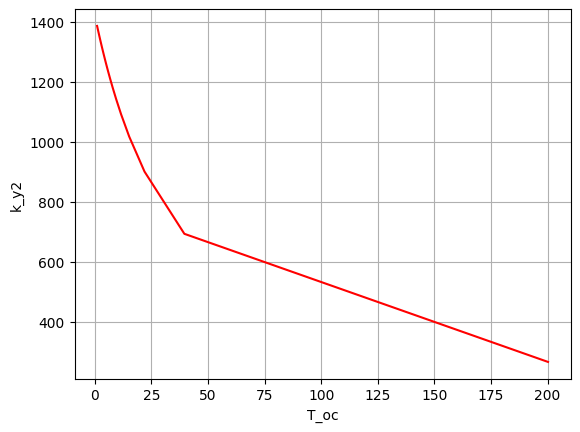

In [94]:
# Строим график k_у2
k_y2_values = [f(k_у2, T_ос, T_ос_value) for T_ос_value in T_ос_values]

plt.plot(T_ос_values, k_y2_values, color='red', label='k_у2')
plt.xlabel('T_ос')
plt.ylabel('k_у2')
plt.grid(True)
plt.show()

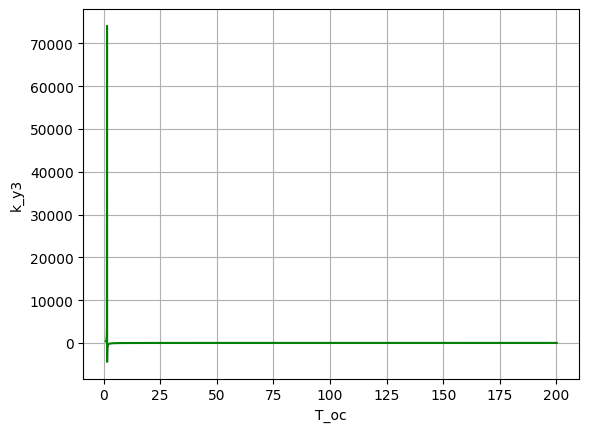

In [95]:
# Строим график k_у3
k_y3_values = [f(k_у3, T_ос, T_ос_value) for T_ос_value in T_ос_values]

plt.plot(T_ос_values, k_y3_values, color='green', label='k_у3')
plt.xlabel('T_ос')
plt.ylabel('k_у3')
plt.grid(True)
plt.show()

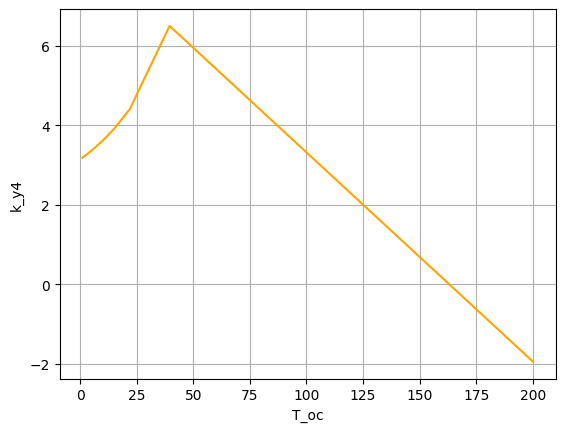

In [96]:
# Строим график k_у4
k_y4_values = [f(k_у4, T_ос, T_ос_value) for T_ос_value in T_ос_values]

plt.plot(T_ос_values, k_y4_values, color='orange', label='k_у4')
plt.xlabel('T_ос')
plt.ylabel('k_у4')
plt.grid(True)
plt.show()

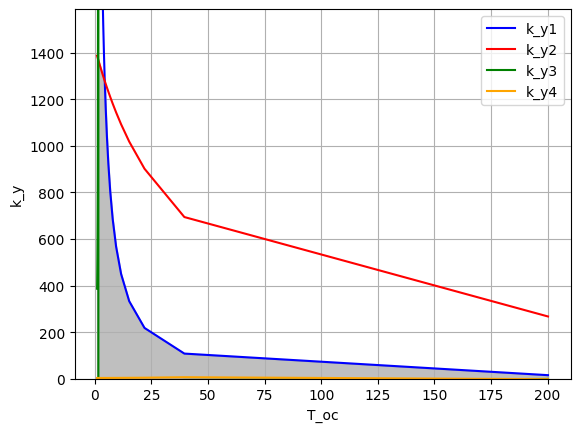

In [97]:
# Построим все графики на одном полотне чтобы получить представление о рабочей области
k_y1_values = [f(k_у1, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y2_values = [f(k_у2, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y3_values = [f(k_у3, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y4_values = [f(k_у4, T_ос, T_ос_value) for T_ос_value in T_ос_values]
# В качестве лимита по оси Y выберем максимальное значение k_у2
y_limit = max(k_y2_values)
plt.ylim(0, y_limit+200)
plt.plot(T_ос_values, k_y1_values, label='k_у1', color='blue')
plt.plot(T_ос_values, k_y2_values, label='k_у2', color='red')

# Штрихуем рабочую область
max_k_y = np.minimum(k_y1_values, k_y2_values)
plt.fill_between(T_ос_values, 0, max_k_y, color='gray', alpha=0.5)

plt.plot(T_ос_values, k_y3_values, label='k_у3', color='green')
plt.plot(T_ос_values, k_y4_values, label='k_у4', color='orange')
# Добавим описание для каждого графика
plt.legend()
plt.xlabel('T_ос')
plt.ylabel('k_у')
plt.grid(True)
plt.show()

In [99]:
# Выведем таблицу значений коэффициентов на 10 значений
T_ос_values = np.linspace(start_value, end_value, 10)
k_y1_values = [f(k_у1, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y2_values = [f(k_у2, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y3_values = [f(k_у3, T_ос, T_ос_value) for T_ос_value in T_ос_values]
k_y4_values = [f(k_у4, T_ос, T_ос_value) for T_ос_value in T_ос_values]
table = np.array([T_ос_values, k_y1_values, k_y2_values, k_y3_values, k_y4_values])
# Округлим значения до 2 знаков после запятой
table = np.round(table, 2)

column_names = ['T_ос', 'k_у1', 'k_у2', 'k_у3', 'k_у4']
df = pd.DataFrame(table.T, columns=column_names)

df

,T_ос,k_у1,k_у2,k_у3,k_у4
0,0.10,58865.43,1419.10,143.26,3.15
1,1.98,2912.47,1354.18,-459.28,3.23
2,3.86,1463.24,1294.51,-88.21,3.31
3,5.73,964.54,1239.52,-48.78,3.40
4,7.61,712.76,1188.72,-33.71,3.49
5,9.49,561.26,1141.69,-25.76,3.59
6,11.37,460.29,1098.04,-20.84,3.69
7,13.24,388.34,1057.45,-17.49,3.80
8,15.12,334.56,1019.63,-15.08,3.92
9,17.00,292.92,984.32,-13.24,4.04


### Расчёт времени переходного процесса

$$ t~п = 3 * (A2 / A3) $$

In [102]:
# Рассчитаем значение T_ос для заданного k_у
k_у_value = 20

def f_T_ос(k_у_value, a2=A2, a3=A3):
    # Подставляем значение k_у в уравнения A2 и A3
    a2 = a2.subs(k_у, k_у_value)
    a3 = a3.subs(k_у, k_у_value)
    # Находим T_ос из уравнения переходного процесса
    
    _t_п = (3 * (a2 / a3))
    
    result = solve(_t_п, T_ос)
    return abs(float(list(result)[0]))

r(f_T_ос(k_у_value))

10.04

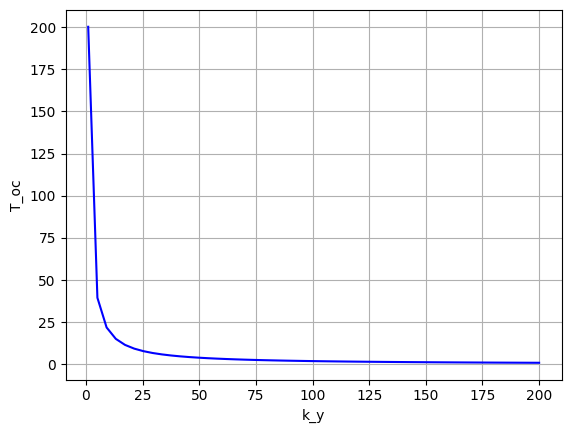

In [100]:
# Строим график зависимости T_ос от k_у
k_у_values = np.linspace(1, 200, 50)

T_ос_values = [f_T_ос(k_у_value) for k_у_value in k_у_values]

plt.plot(k_у_values, T_ос_values, color='blue', label='T_ос')
plt.xlabel('k_у')
plt.ylabel('T_ос')
plt.grid(True)
plt.show()